In [ ]:
import zipfile
import os
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import classification_report


In [ ]:
import zipfile
import os

# Paths to your zip files
zip_paths = [
    "/content/Blue Tailed Bee Eater.zip",
    "/content/Red Vented Bul Bul.zip",
    "/content/White throted kingfisher.zip",
    "/content/unknown.zip"
]

# Unzipping function
def unzip_files(zip_paths, extract_to_base):
    for zip_path in zip_paths:
        # Get the folder name based on the zip file name
        folder_name = os.path.splitext(os.path.basename(zip_path))[0]
        extract_to = os.path.join(extract_to_base, folder_name)

        os.makedirs(extract_to, exist_ok=True)
        print(f"Unzipping {zip_path} to {extract_to}...")

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Finished unzipping {zip_path} to {extract_to}")

# Unzip all files to separate directories for each bird
extracted_base_dir = "/content/extracted_images"
unzip_files(zip_paths, extracted_base_dir)


Unzipping /content/Blue Tailed Bee Eater.zip to /content/extracted_images/Blue Tailed Bee Eater...
Finished unzipping /content/Blue Tailed Bee Eater.zip to /content/extracted_images/Blue Tailed Bee Eater
Unzipping /content/Red Vented Bul Bul.zip to /content/extracted_images/Red Vented Bul Bul...
Finished unzipping /content/Red Vented Bul Bul.zip to /content/extracted_images/Red Vented Bul Bul
Unzipping /content/White throted kingfisher.zip to /content/extracted_images/White throted kingfisher...
Finished unzipping /content/White throted kingfisher.zip to /content/extracted_images/White throted kingfisher
Unzipping /content/unknown.zip to /content/extracted_images/unknown...
Finished unzipping /content/unknown.zip to /content/extracted_images/unknown


In [ ]:
# Function to split and organize datasets
def split_and_organize_datasets(base_extracted_dir, split_base_dir, test_size=0.2, val_size=0.2):
    if os.path.exists(split_base_dir):
        shutil.rmtree(split_base_dir)
    os.makedirs(split_base_dir, exist_ok=True)
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(split_base_dir, split), exist_ok=True)

    for bird_folder in os.listdir(base_extracted_dir):
        bird_dir = os.path.join(base_extracted_dir, bird_folder)
        if not os.path.isdir(bird_dir):
            continue
        images = [img for img in os.listdir(bird_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]
        if len(images) == 0:
            continue
        train_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=42)
        train_imgs, val_imgs = train_test_split(train_imgs, test_size=val_size, random_state=42)
        for split, imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            split_dir = os.path.join(split_base_dir, split, bird_folder)
            os.makedirs(split_dir, exist_ok=True)
            for img in imgs:
                shutil.copy(os.path.join(bird_dir, img), os.path.join(split_dir, img))

# Split dataset
split_base_dir = "/content/split_datasets"
split_and_organize_datasets(extracted_base_dir, split_base_dir)


In [ ]:
# Function to augment training data by flipping images
def augment_training_data(train_dir):
    for bird_folder in os.listdir(train_dir):
        bird_folder_path = os.path.join(train_dir, bird_folder)
        if not os.path.isdir(bird_folder_path):
            continue
        for img_name in os.listdir(bird_folder_path):
            img_path = os.path.join(bird_folder_path, img_name)
            if img_path.endswith(('.jpg', '.jpeg', '.png')):
                img = load_img(img_path)
                img_array = img_to_array(img)
                flipped_img_array = np.fliplr(img_array)  # Flip image
                flipped_img = array_to_img(flipped_img_array)
                flipped_img.save(os.path.join(bird_folder_path, f"flipped_{img_name}"))

# Augment training data
train_dir = os.path.join(split_base_dir, 'train')
augment_training_data(train_dir)

# ImageDataGenerator setup
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_gen = val_datagen.flow_from_directory(os.path.join(split_base_dir, 'val'), target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_gen = test_datagen.flow_from_directory(os.path.join(split_base_dir, 'test'), target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)


Found 2560 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [ ]:
# Load the MobileNetV2 model with pre-trained weights
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')


base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

for layer in base_model.layers[-15:]:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = tf.keras.regularizers.l2(0.005)

# Create the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),  # Increased neurons
    Dropout(0.15),  # Reduced dropout
    Dense(train_gen.num_classes, activation='softmax')
])

# Compile the model with label smoothing
model.compile(
    optimizer=Adam(learning_rate=3e-5),  # Increased learning rate
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),  # Label smoothing to reduce overconfidence
    metrics=['accuracy']
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Train model
epochs = 10
history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=1)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.5234 - loss: 5.7582 - val_accuracy: 0.7812 - val_loss: 5.1913
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.8886 - loss: 4.8834 - val_accuracy: 0.8531 - val_loss: 4.8433
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.9379 - loss: 4.5940 - val_accuracy: 0.8781 - val_loss: 4.5795
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.9580 - loss: 4.3655 - val_accuracy: 0.9062 - val_loss: 4.3447
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.9757 - loss: 4.1582 - val_accuracy: 0.9312 - val_loss: 4.1285
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.9782 - loss: 3.9693 - val_accuracy: 0.9469 - val_loss: 3.9199
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.9823 - loss: 3.7785 - val_accuracy: 0.9500 - val_loss: 3.7221
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.9920 - loss: 3.5838 - val_accuracy: 0.9531 - val_loss: 3.

In [ ]:

average_training_accuracy = sum(history.history['accuracy']) / len(history.history['accuracy'])
print(f"Average Training Accuracy: {average_training_accuracy * 100:.2f}%")

test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=-1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))


Average Training Accuracy: 94.14%
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9596 - loss: 3.1586
Test Accuracy: 95.25%
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
Classification Report:
                          precision    recall  f1-score   support

   Blue Tailed Bee Eater       0.95      0.99      0.97       100
      Red Vented Bul Bul       0.99      0.89      0.94       100
White throted kingfisher       0.96      0.93      0.94       100
                 unknown       0.92      1.00      0.96       100

                accuracy                           0.95       400
               macro avg       0.95      0.95      0.95       400
            weighted avg       0.95      0.95      0.95       400



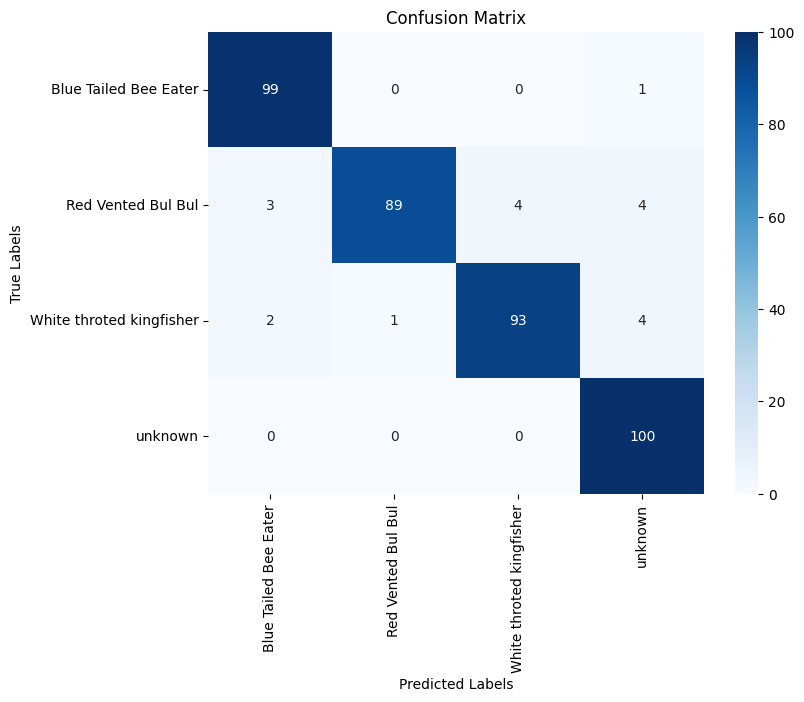

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:

model.save("/content/check_try_model.h5")
from google.colab import files
files.download("/content/check_try_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>